In [7]:
import os
import platform
import cv2 as cv
import json
import numpy as np
import tensorflow as tf
import pandas as pd

from sys import path
path.insert(0, '..')
import counting_car.model as model
import counting_car.config as config
import counting_car.utill as utill
import counting_car.layer as layer

In [8]:
with open('../assets/dataset/gt_train.txt') as file:
  data = json.load(file)

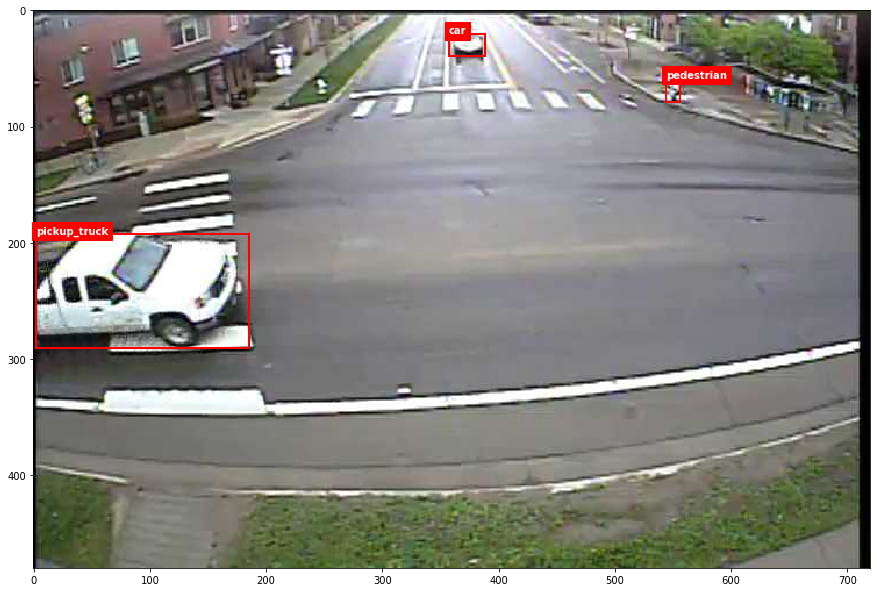

In [43]:
s = 100
img = utill.open_image(os.path.join('../assets/dataset/train',data[s]['filename']), False)
utill.draw_image(img, data[s])

In [10]:
class_name = [line.strip() for line in open('../config/class_name_2.txt').readlines()]

In [20]:
interpreter = tf.lite.Interpreter(model_path='../config/model_2.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(len(input_details))
print(len(output_details))

1
3


In [62]:
index = [ output_details[i]['index'] for i in range(len(output_details))]
index.sort()
print(index)

[732, 749, 766]


In [44]:
def img_process(img, shape):
  img_ori = tf.image.resize(img, (input_details[0]['shape'][1], input_details[0]['shape'][1]))
  img_ori = img_ori / 255
  img_exp = np.expand_dims(img_ori, axis=0)
  return img_exp

In [45]:
imgf = img_process(img, input_details)
print(imgf.shape)

(1, 416, 416, 3)


In [46]:
interpreter.set_tensor(input_details[0]['index'], imgf)
interpreter.invoke()

In [63]:
anchors = np.array(config.cfg['anchors']).reshape((3, 5, 2))
index = [ output_details[i]['index'] for i in range(len(output_details))]
index.sort()
outputs = [interpreter.get_tensor(i) for i in index]


outputs = layer.yolo_detector(outputs, anchors, len(class_name) , config.cfg['strides'], config.cfg['xyscale'])
outputs = utill.nms(outputs, config.cfg_lite['image_size'], len(class_name), config.cfg_lite['iou_threshold'], config.cfg_lite['score_threshold'])
boxes = utill.get_detection_data(outputs, img.shape, class_name)
boxes = utill.filtter(boxes, 0.7)

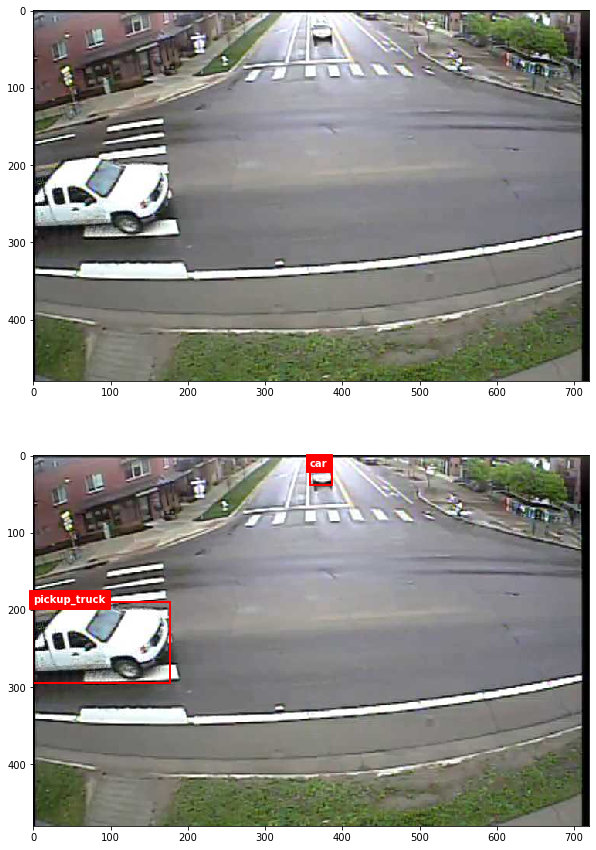

In [64]:
utill.plot_bbox(img, boxes, True)

In [42]:
print(boxes)

    x1   y1   x2   y2    class_name    score    w    h
0  372  193  720  420  pickup_truck  0.99107  348  227
